# CAPSTONE PROJECT - AD RECOMMENDER SYSTEM

## Surbhi Sinha

### PART1 - EDA, VISUALISATION & DATA PREPARATION

This is Part1 if the notebook, this covers below mentioned tasks:
1. Reading the data
2. Data Cleanup
3. EDA & Visualtion (Basic and Advanced)
4. Feature Data Preparation

In [85]:
# Install all dependencies
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [86]:
# Add all required imports
import pandas as pd
import numpy as np
import os

# For EDA & Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# For Geospacial visualisation
from mpl_toolkits.basemap import Basemap

# For location based clustering
from sklearn.cluster import DBSCAN

# For preprocessing of data
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
import category_encoders as category_encoders

import warnings
warnings.filterwarnings("ignore")

## 1. Reading Data

In [87]:
# This is first data set which has data of all device id with the corresponding gender, age, phone brand & device model
train_mobile_brand_df = pd.read_csv("data/train_mobile_brand.csv")

In [88]:
train_mobile_brand_df.head()

,device_id,gender,age,group_train,phone_brand,device_model
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C
1,6943568600617760000,M,37,M32+,Xiaomi,xnote
2,5441349705980020000,M,40,M32+,OPPO,R7s
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4


In [89]:
train_mobile_brand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74840 entries, 0 to 74839
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   device_id     74840 non-null  int64 
 1   gender        74840 non-null  object
 2   age           74840 non-null  int64 
 3   group_train   74840 non-null  object
 4   phone_brand   74840 non-null  object
 5   device_model  74840 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.4+ MB


In [90]:
# This is second data set which has all the device id and the event_id and the time & location of event 
train_event_data_df = pd.read_csv("data/train_event_data.csv")

In [91]:
train_event_data_df.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79


In [92]:
train_event_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266933 entries, 0 to 1266932
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   device_id      1266933 non-null  int64  
 1   gender         1266933 non-null  object 
 2   age            1266933 non-null  int64  
 3   group_train    1266933 non-null  object 
 4   event_id       1215598 non-null  float64
 5   datetimestamp  1215598 non-null  object 
 6   latitude       1215598 non-null  float64
 7   longitude      1215598 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 77.3+ MB


In [93]:
# This is third data set which has the app_id for the event id and the app status if it is installed or active
app_event_df = pd.read_csv("data/app_events.csv")

In [94]:
app_event_df.head()

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [95]:
app_event_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
 #   Column        Dtype
---  ------        -----
 0   event_id      int64
 1   app_id        int64
 2   is_installed  int64
 3   is_active     int64
dtypes: int64(4)
memory usage: 991.0 MB


In [96]:
# This is 4th data set which contains the app_id and the corresponding label_id and app category
dtype = {"0": int, "1": int, "2": str}

# We are skipping two rows. Row1 contains the title and not actual data, and row 420939 has an EOF character which fails the parsing of file
app_event_meta_data_df = pd.read_csv("data/app_events_meta_data.csv", skiprows=[1, 420939], dtype=dtype)
app_event_meta_data_df.head()

,app_id,label_id,category
0,7324884708820027918,251,Finance
1,-4494216993218550286,251,Finance
2,6058196446775239644,406,unknown
3,6058196446775239644,407,DS_P2P net loan
4,8694625920731541625,406,unknown


In [97]:
app_event_meta_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420937 entries, 0 to 420936
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   app_id    420937 non-null  int64 
 1   label_id  420937 non-null  int64 
 2   category  420937 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.6+ MB


## 2. Data cleanup

In the dataframe `train_mobile_brand_df` above we have seen that multiple device model containing garbage string such as `è£è€€3C`. We would want to filter these unwanted characters to ASCII Characters only

In [98]:
train_mobile_brand_df.head()

,device_id,gender,age,group_train,phone_brand,device_model
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C
1,6943568600617760000,M,37,M32+,Xiaomi,xnote
2,5441349705980020000,M,40,M32+,OPPO,R7s
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4


In [99]:
#Function to Clean non-ASCII Characters
def cleanString(str):
    if str.isascii():
        return str
        
    else:
        return "".join(list(map(lambda x:x if x.isascii() else "", str)))
        
train_mobile_brand_df["device_model"] = train_mobile_brand_df["device_model"].apply(cleanString)
train_mobile_brand_df.head()

,device_id,gender,age,group_train,phone_brand,device_model
0,-7548291590301750000,M,33,M32+,Huawei,3C
1,6943568600617760000,M,37,M32+,Xiaomi,xnote
2,5441349705980020000,M,40,M32+,OPPO,R7s
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4


As next step we will try to remove any duplicated entries in this data frame by first converting all `phone_brand` & `device_model` to string upper case

In [100]:
# Convert phone_brand & device_model to upper case
train_mobile_brand_df.phone_brand = train_mobile_brand_df.phone_brand.str.upper()
train_mobile_brand_df.device_model = train_mobile_brand_df.device_model.str.upper()

# See duplicated values in this dataframe
print("Duplicate values before cleaning:")
train_mobile_brand_df.duplicated().value_counts(dropna=False)

Duplicate values before cleaning:


False    74646
True       194
Name: count, dtype: int64

In [101]:
# Drop all duplicates
train_mobile_brand_df.drop_duplicates(subset=None, keep="first", inplace=True)

# See duplicated values in this dataframe after cleaning
print("Duplicate values after cleaning:")
train_mobile_brand_df.duplicated().value_counts(dropna=False)

Duplicate values after cleaning:


False    74646
Name: count, dtype: int64

In `train_event_data_df` we will first convert datetimestamp pbject to pandas datetime

In [102]:
train_event_data_df["datetimestamp"]=pd.to_datetime(train_event_data_df["datetimestamp"])
train_event_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266933 entries, 0 to 1266932
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   device_id      1266933 non-null  int64         
 1   gender         1266933 non-null  object        
 2   age            1266933 non-null  int64         
 3   group_train    1266933 non-null  object        
 4   event_id       1215598 non-null  float64       
 5   datetimestamp  1215598 non-null  datetime64[ns]
 6   latitude       1215598 non-null  float64       
 7   longitude      1215598 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 77.3+ MB


We will now create additional columns such as hour, day of week etc for EDA below

In [103]:
train_event_data_df['day_of_week'] = train_event_data_df['datetimestamp'].dt.day_name()
train_event_data_df['hour'] = train_event_data_df['datetimestamp'].dt.hour

We will also add another column representing age group in 4 bins of 0-24, 25-32, 33-45. 46+. This will be used in EDA below

In [104]:
train_event_data_df['age_group'] = pd.cut(train_event_data_df['age'], bins=[0, 24, 32, 45, float('inf')], labels=['0-24', '25-32', '33-45', '46+'])

In [105]:
train_event_data_df.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude,day_of_week,hour,age_group
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79,Tuesday,15.0,33-45
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79,Tuesday,6.0,33-45
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79,Wednesday,3.0,33-45
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79,Wednesday,2.0,33-45
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79,Tuesday,15.0,33-45


- Splitting the train_event_data into scenario 1 and scenario 2
- Scenario 1 - A user enables the location on their device while using an app. In a way, the location or event id generated against any activity will have location data.
- Scenario 2 - The user activity is unavailable, thereby leaving you with only device information.

In [106]:
train_events_with_location = train_event_data_df.dropna(subset=['latitude', 'longitude'])
train_events_without_location = train_event_data_df[train_event_data_df['latitude'].isnull() | train_event_data_df['longitude'].isnull()]

train_events_with_location["coordinates"] = train_events_with_location[["latitude", "longitude"]].apply(lambda x: (x["latitude"], x["longitude"]), axis = 1)

In [107]:
train_events_with_location.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1215598 entries, 0 to 1251632
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   device_id      1215598 non-null  int64         
 1   gender         1215598 non-null  object        
 2   age            1215598 non-null  int64         
 3   group_train    1215598 non-null  object        
 4   event_id       1215598 non-null  float64       
 5   datetimestamp  1215598 non-null  datetime64[ns]
 6   latitude       1215598 non-null  float64       
 7   longitude      1215598 non-null  float64       
 8   day_of_week    1215598 non-null  object        
 9   hour           1215598 non-null  float64       
 10  age_group      1215598 non-null  category      
 11  coordinates    1215598 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 112.5+ MB


In [108]:
train_events_with_location.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude,day_of_week,hour,age_group,coordinates
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79,Tuesday,15.0,33-45,"(33.98, 116.79)"
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79,Tuesday,6.0,33-45,"(33.98, 116.79)"
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79,Wednesday,3.0,33-45,"(33.98, 116.79)"
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79,Wednesday,2.0,33-45,"(33.98, 116.79)"
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79,Tuesday,15.0,33-45,"(33.98, 116.79)"


We will now validate that all of these events have a valid event_id

In [109]:
assert train_events_with_location[train_events_with_location['event_id'].isnull()].size == 0, "Corrputed data, Data with valid lat, long have invalid eventID"

In [110]:
train_events_without_location.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude,day_of_week,hour,age_group
1215595,398514470209561000,M,68,M32+,NaN,NaT,NaN,NaN,NaN,NaN,46+
1215596,-3073918292047050000,M,27,M25-32,NaN,NaT,NaN,NaN,NaN,NaN,25-32
1215597,5805880616488060000,M,39,M32+,NaN,NaT,NaN,NaN,NaN,NaN,33-45
1215598,-2403560729305410000,M,25,M25-32,NaN,NaT,NaN,NaN,NaN,NaN,25-32
1215599,-1889893391998300000,M,22,M0-24,NaN,NaT,NaN,NaN,NaN,NaN,0-24


In [111]:
train_events_without_location.nunique()

device_id        51335
gender               2
age                 84
group_train          6
event_id             0
datetimestamp        0
latitude             0
longitude            0
day_of_week          0
hour                 0
age_group            4
dtype: int64

We see that `event_id`, `datetimestamp`, `latitude`, `longitude`, `day_of_week`, `hour` doesn't have any values so we will drop these columns

In [112]:
columns_to_drop = ['event_id', 'datetimestamp', 'latitude', 'longitude', 'day_of_week', 'hour']
train_events_without_location = train_events_without_location.drop(columns=columns_to_drop)

In [113]:
train_events_without_location.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51335 entries, 1215595 to 1266932
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   device_id    51335 non-null  int64   
 1   gender       51335 non-null  object  
 2   age          51335 non-null  int64   
 3   group_train  51335 non-null  object  
 4   age_group    51335 non-null  category
dtypes: category(1), int64(2), object(2)
memory usage: 2.0+ MB


## 3. Basic EDA and Visualisation

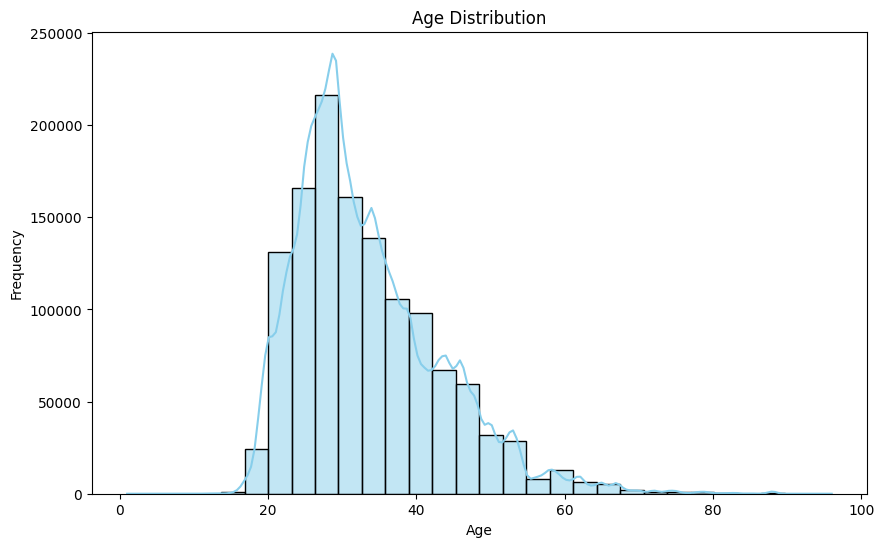

In [114]:
# Univariate analysis: Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_event_data_df['age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

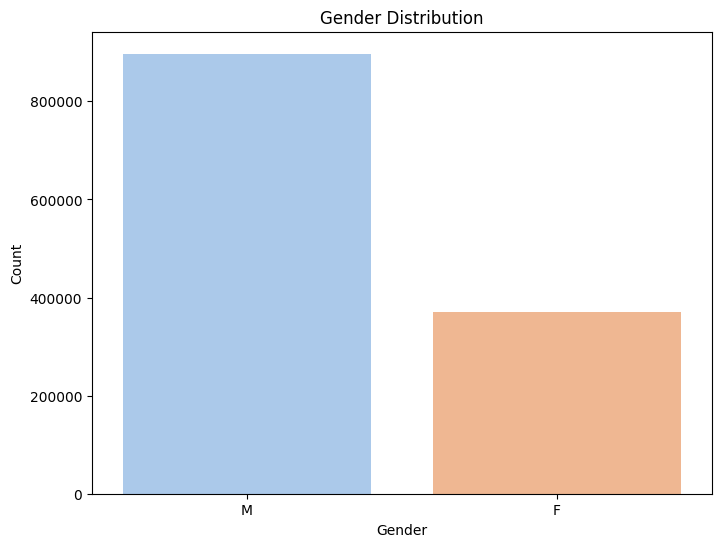

In [115]:
# Univariate analysis: Gender distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=train_event_data_df, palette='pastel', hue='gender', legend=False)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

From this plot we see that Male Population consists of roughly 75% of the over all events in the data set. So the data set is skewed for Males


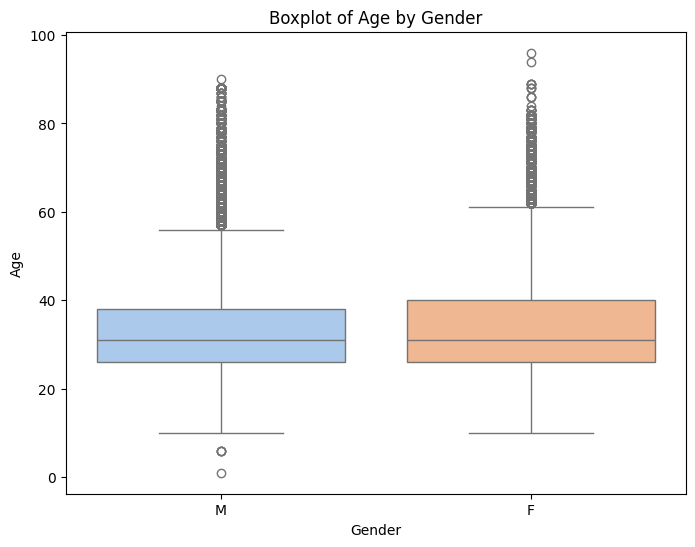

In [116]:
# Bivariate analysis: Boxplot of age by gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='age', data=train_event_data_df, palette='pastel', hue='gender', legend=False)
plt.title('Boxplot of Age by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

From this boxplot we see that the age distribution for Males and Females is approximately the same with same mean and similar min and max values.


#### Trends in event data (devices, days of the week, hours, gender, and age groups):

- Plot percentage of device_ids with and without event data
- Graph representing the distribution of events on different days of a week
- Graph representing the distribution of events per hour (for one-week data)
- The difference in the distribution of events per hour for males and females (Show the difference using an appropriate chart for one week’s data)
- Is there any difference in the distribution of events for different age groups over different days of week? (Consider the age groups as 0–24, 25–32, 33–45, 46+]

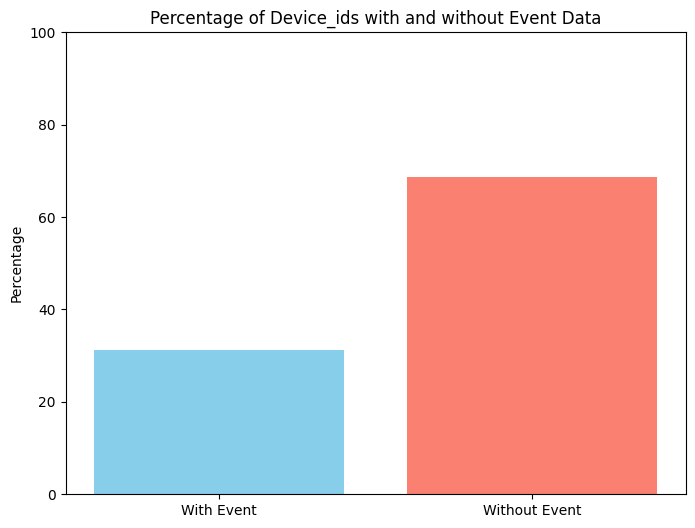

Total % of devices with event data =  31.227811641771048
Total % of devices without event data =  68.77218835822895


In [117]:
# 1. Percentage of device_ids with and without event data
total_devices = len(train_event_data_df['device_id'].unique())
devices_with_event = len(train_event_data_df.dropna(subset=['event_id'])['device_id'].unique())
devices_without_event = total_devices - devices_with_event
percentage_with_event = (devices_with_event / total_devices) * 100
percentage_without_event = (devices_without_event / total_devices) * 100

# Plotting the percentage of device_ids with and without event data
plt.figure(figsize=(8, 6))
plt.bar(['With Event', 'Without Event'], [percentage_with_event, percentage_without_event], color=['skyblue', 'salmon'])
plt.title('Percentage of Device_ids with and without Event Data')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.show()

# Printing the percentage with and without event data
print("Total % of devices with event data = ", percentage_with_event)
print("Total % of devices without event data = ", percentage_without_event)


`Analysis`: From this graph we see that only 31% of devices have event data getting generated along with it. while 68% devices have no events getting generated from them.

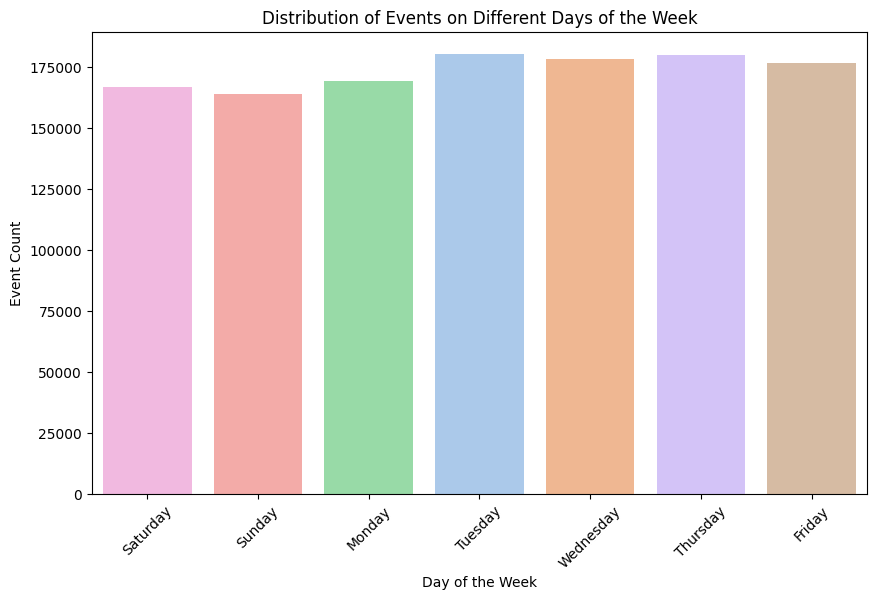

In [118]:
# 2. Distribution of events on different days of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=train_event_data_df, order=['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
              palette='pastel', hue = 'day_of_week', legend=False)
plt.title('Distribution of Events on Different Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Event Count')
plt.xticks(rotation=45)
plt.show()

We see that the usage on different days of the week mostly remains the same without much significant change. However the mobile usage is lesser on weekends as compared to week days.


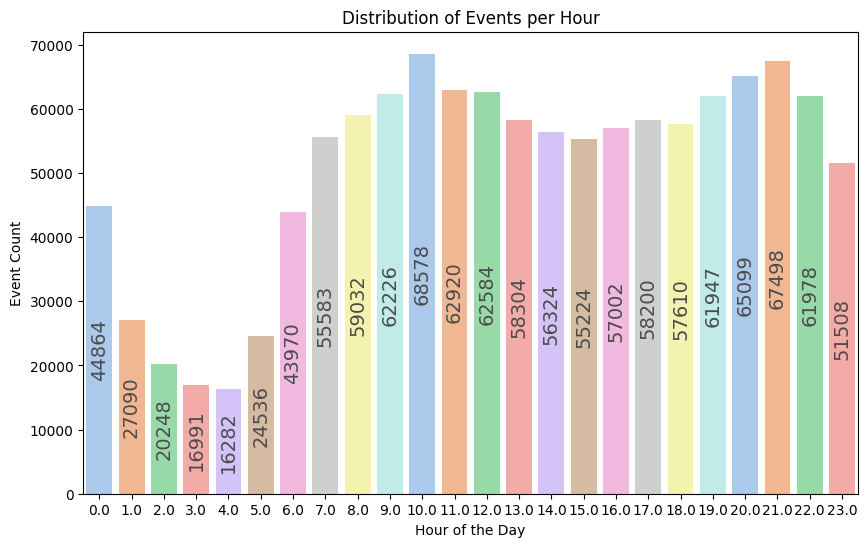

In [119]:
# 3. Distribution of events per hour
plt.figure(figsize=(10, 6))
cnt_plot = sns.countplot(x='hour', data=train_event_data_df, palette='pastel', hue='hour', legend=False)
plt.title('Distribution of Events per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Event Count')
for x in cnt_plot.containers:
    cnt_plot.bar_label(x, label_type='center', color='#4b4b4b', fontsize=14, rotation = 90)
plt.show()

In this we see that the no of events is highest in Mornings and Evenings which could signify people use mobile phones while travelling to office.

While the events drops significantly during night time when people are asleep.

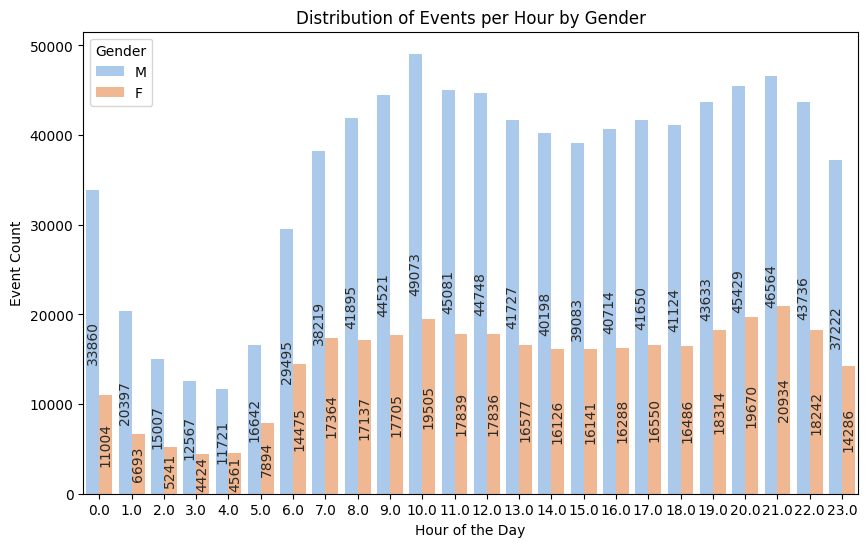

In [120]:
# 4. Difference in the distribution of events per hour for males and females (for one week's data)
plt.figure(figsize=(10, 6))
cnt_plot = sns.countplot(x='hour', data=train_event_data_df, hue='gender', palette='pastel')
plt.title('Distribution of Events per Hour by Gender')
plt.xlabel('Hour of the Day')
plt.ylabel('Event Count')
plt.legend(title='Gender')
for x in cnt_plot.containers:
    cnt_plot.bar_label(x, label_type='center', color='#2b2b2b', fontsize=10, rotation = 90)
plt.show()

In this we see the trend doesn’t change significantly for males vs females however for males the peak at morning and evening is more significant.

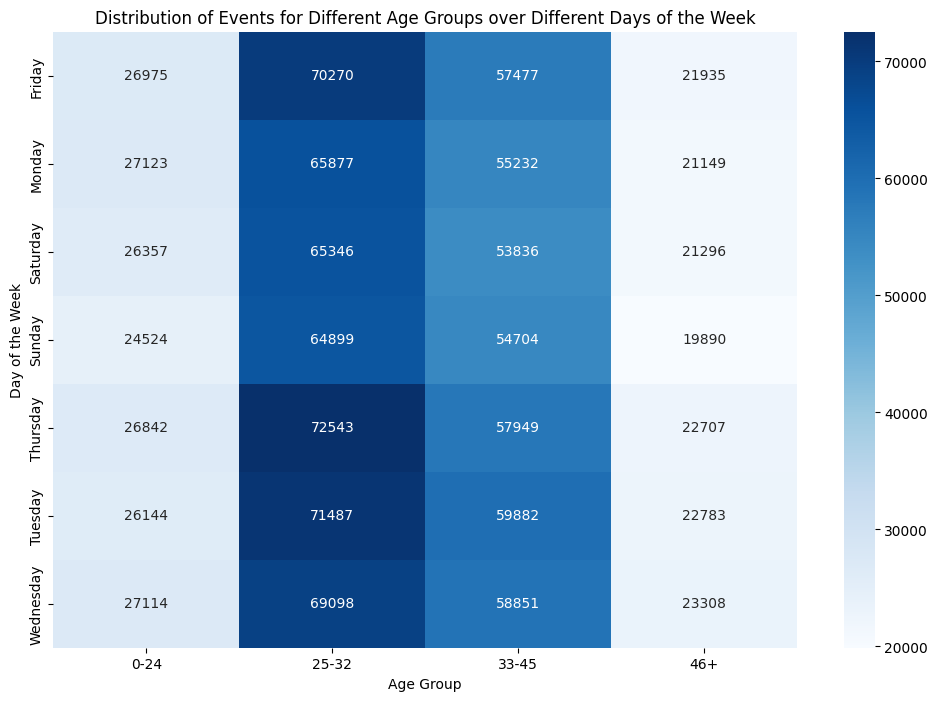

In [121]:
# 5. Difference in the distribution of events for different age groups over different days of the week
# Define age groups
plt.figure(figsize=(12, 8))
heatmap_data = train_event_data_df.groupby(['day_of_week', 'age_group'], observed=False).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d')
plt.title('Distribution of Events for Different Age Groups over Different Days of the Week')
plt.xlabel('Age Group')
plt.ylabel('Day of the Week')
plt.show()

App usage is highest for the 25-32 age group, followed by the 33-45 age group. 

Younger and older age groups show lower usage and exhibit less variance in their data distribution throughout the week.


#### EDA on Phone Brand and Application Preferences:
- Stacked bar chart for the top 10 mobile brands across male and female consumers
- Chart representing 10 frequent applications and the corresponding percentage of male and female consumers
- Top 10 mobile phone brands by age groups (Consider the age groups as 0–24, 25–32, 33–45, 46+.)

**Stacked bar chart for the top 10 mobile brands across male and female consumers**

<Figure size 1000x600 with 0 Axes>

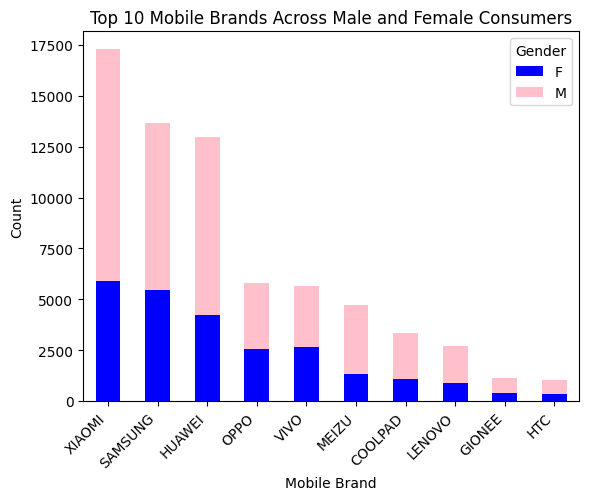

In [122]:
# Grouping by phone brand and gender and counting the number of occurrences
brand_gender_counts = train_mobile_brand_df.groupby(['phone_brand', 'gender']).size().unstack().fillna(0)

# Sorting by total count of each brand
brand_gender_counts['total'] = brand_gender_counts.sum(axis=1)
brand_gender_counts = brand_gender_counts.sort_values(by='total', ascending=False).head(10)

# Selecting only the top 10 brands
brand_gender_counts = brand_gender_counts.drop(columns='total')

# Plotting stacked bar chart
plt.figure(figsize=(10, 6))
brand_gender_counts.plot(kind='bar', stacked=True, color=['blue', 'pink'])
plt.title('Top 10 Mobile Brands Across Male and Female Consumers')
plt.xlabel('Mobile Brand')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.show()

From this we see that the top most used brand for males and females is XIAOMI followed by  Samsung  & Huawei.

After the top 3, and next 5, the brand uses decreases exponentially.


**Chart representing 10 frequent applications and the corresponding percentage of male and female consumers**

In [123]:
app_event_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
 #   Column        Dtype
---  ------        -----
 0   event_id      int64
 1   app_id        int64
 2   is_installed  int64
 3   is_active     int64
dtypes: int64(4)
memory usage: 991.0 MB


In [124]:
# Prepare the merged data frame with `train_events_with_location` , `app_event_df` & `app_event_meta_data_df`

# Merge dataframes
merged_df_for_apps = pd.merge(train_events_with_location, app_event_df, how='inner', on='event_id')

merged_df_for_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12237254 entries, 0 to 12237253
Data columns (total 15 columns):
 #   Column         Dtype         
---  ------         -----         
 0   device_id      int64         
 1   gender         object        
 2   age            int64         
 3   group_train    object        
 4   event_id       float64       
 5   datetimestamp  datetime64[ns]
 6   latitude       float64       
 7   longitude      float64       
 8   day_of_week    object        
 9   hour           float64       
 10  age_group      category      
 11  coordinates    object        
 12  app_id         int64         
 13  is_installed   int64         
 14  is_active      int64         
dtypes: category(1), datetime64[ns](1), float64(4), int64(5), object(4)
memory usage: 1.3+ GB


In [125]:
merged_df_for_apps.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude,day_of_week,hour,age_group,coordinates,app_id,is_installed,is_active
0,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",3433289601737013244,1,1
1,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",-5472633337921616096,1,1
2,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",9112463114311278255,1,0
3,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",8693964245073640147,1,1
4,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",5099453940784075687,1,1


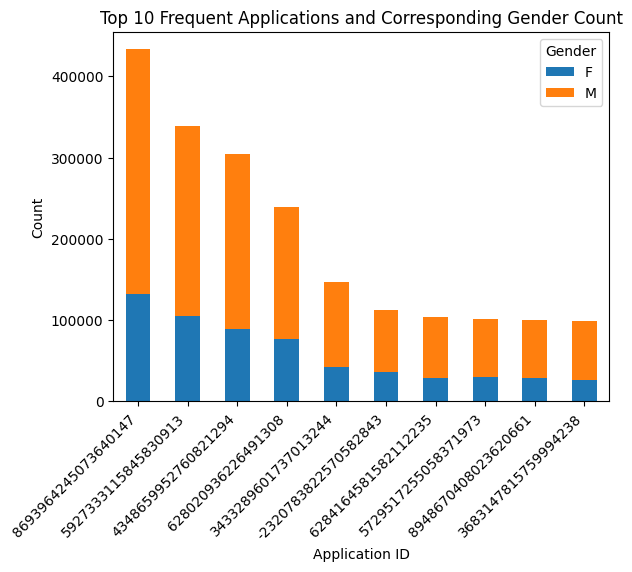

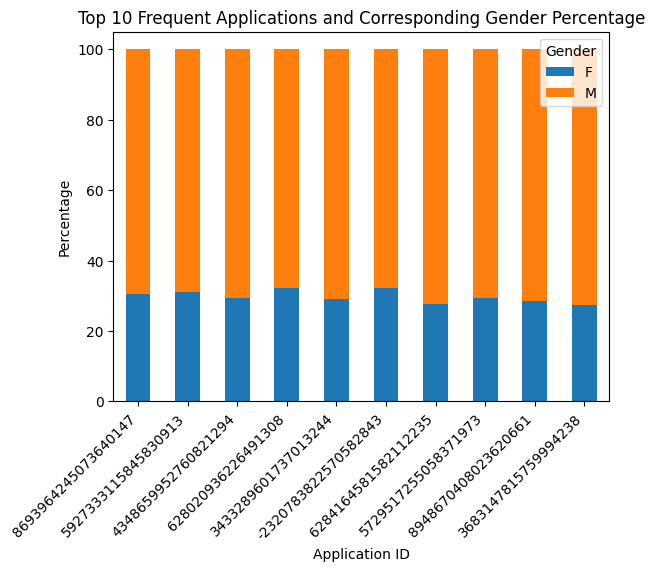

In [126]:
# Grouping by phone app_id and gender and counting the number of occurrences
app_id_gender_counts = merged_df_for_apps.groupby(['app_id', 'gender']).size().unstack().fillna(0)

# Sorting by total count of each app_id
app_id_gender_counts['total'] = app_id_gender_counts.sum(axis=1)
app_id_gender_counts = app_id_gender_counts.sort_values(by='total', ascending=False).head(10)

#Calculating percentage of male and female for each phone brand
app_gender_counts_percentage = app_id_gender_counts.div(app_id_gender_counts['total'], axis=0) * 100

# Droping the total column
app_id_gender_counts = app_id_gender_counts.drop(columns='total')
app_gender_counts_percentage = app_gender_counts_percentage.drop(columns='total')

# Plotting stacked bar chart
app_id_gender_counts.plot(kind='bar', stacked=True)
plt.title('Top 10 Frequent Applications and Corresponding Gender Count')
plt.xlabel('Application ID')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.show()

# Plotting stacked bar chart
app_gender_counts_percentage.plot(kind='bar', stacked=True)
plt.title('Top 10 Frequent Applications and Corresponding Gender Percentage')
plt.xlabel('Application ID')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.show()


Most frequent app is with ID 8693964245073640147. 

After  the first 4-5 Apps the frequency of next set of apps decreases exponentially in this case as well.


**Top 10 mobile phone brands by age groups (Consider the age groups as 0–24, 25–32, 33–45, 46+.)**

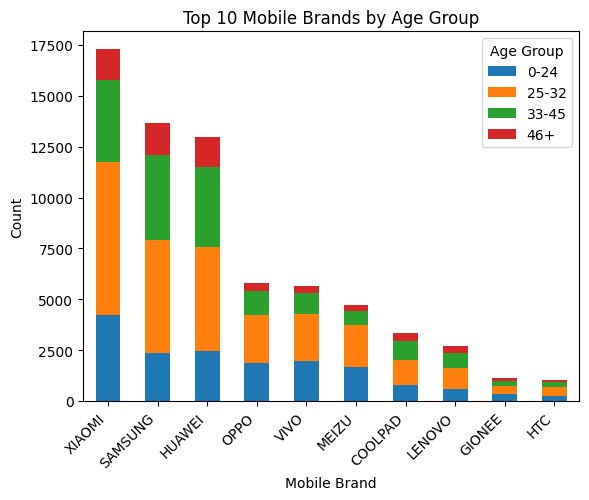

In [127]:
# Define age groups
train_mobile_brand_df['age_group'] = pd.cut(train_mobile_brand_df['age'], bins=[0, 24, 32, 45, float('inf')], labels=['0-24', '25-32', '33-45', '46+'])

# Grouping by phone brand and age group and counting the number of occurrences
brand_age_counts = train_mobile_brand_df.groupby(['phone_brand', 'age_group'], observed=False).size().unstack().fillna(0)

# Sorting by total count of each brand
brand_age_counts['total'] = brand_age_counts.sum(axis=1)
brand_age_counts = brand_age_counts.sort_values(by='total', ascending=False).head(10)

# Selecting only the top 10 brands
brand_age_counts = brand_age_counts.drop(columns='total')

# Plotting stacked bar chart
brand_age_counts.plot(kind='bar', stacked=True)
plt.title('Top 10 Mobile Brands by Age Group')
plt.xlabel('Mobile Brand')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Age Group')
plt.show()

The mobile brand distribution remains almost the same for age groups 24+ where XIAOMI is the highest and after top 3, uses decrease exponentially.

However for age group 0-24, The usage of first 6 brands is almost the same and doesn’t follows the same trend as other age groups.


## 4. Advanced Visualisation And Clustering

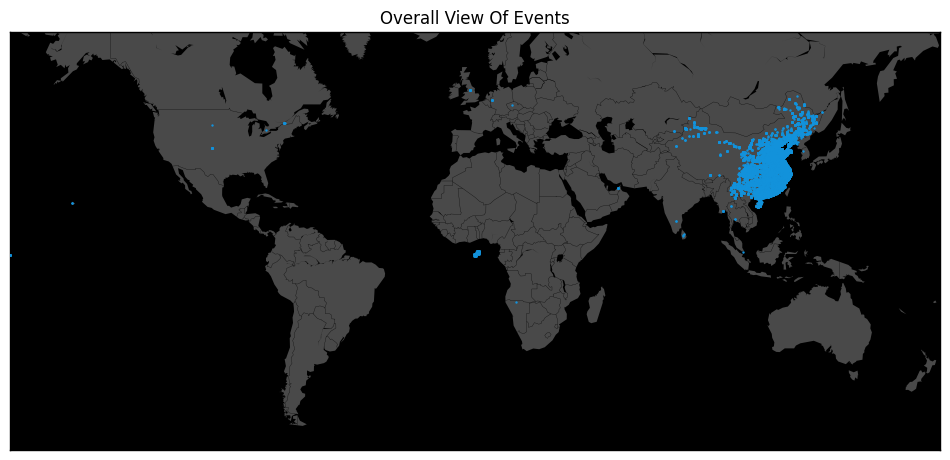

In [128]:

def plot_geospatial_visualisation(dataframe_to_plot, title, lon_min = 75, lon_max = 140, lat_min = 5, lat_max = 60, color = '#1292db'):
    '''
    This function takes in an input of data frame and title and plots it on the world map.
    As per usage of this project, it has default boundaries focusing on east aisa which has maximum concetration of data
    '''
    plt.figure(1, figsize=(12,6))

    # Mercator of World
    # Create a Basemap object
    merc = Basemap(projection='merc', 
                   llcrnrlat=lat_min, urcrnrlat=lat_max,
                   llcrnrlon=lon_min, urcrnrlon=lon_max,
                   lat_ts=0, resolution='c')
    
    # Draw coastlines, countries, and states
    merc.fillcontinents(color="#494949", lake_color="#000000")
    merc.drawmapboundary(fill_color="#000000")
    merc.drawcountries(linewidth=0.2)
    
    # Convert latitude and longitude to Basemap coordinates
    x, y = merc(dataframe_to_plot['longitude'].values, dataframe_to_plot['latitude'].values)
    
    # Plot the data points
    merc.scatter(x, y, s=3, color=color, lw=0, alpha=1, zorder=5)
    
    # Add title and show the plot
    plt.title(title)
    plt.show()
    

# Plotting a sample of dataset on the world map
train_events_with_location_sample = train_events_with_location.sample(n=100000)
plot_geospatial_visualisation(train_events_with_location_sample, 'Overall View Of Events', -180, 180, -60, 65)

As per the above visualisation, we see that most of the users are concentrated in East Asia so we will zoom out to that region

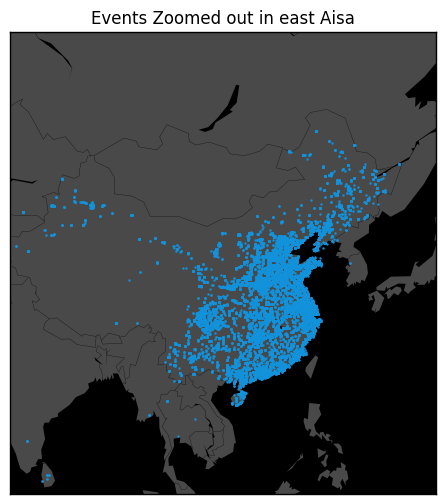

In [129]:
# specific region
lon_min, lon_max = 75, 140
lat_min, lat_max = 5, 60

filter_query = (train_events_with_location['longitude'] > lon_min) &\
               (train_events_with_location['longitude'] < lon_max) &\
               (train_events_with_location['latitude'] > lat_min) &\
               (train_events_with_location['latitude'] < lat_max)

# We will now sample 100,000 data from the events data set
train_events_with_location_sample = train_events_with_location[filter_query].sample(n=100000)
plot_geospatial_visualisation(train_events_with_location_sample, 'Events Zoomed out in east Aisa')

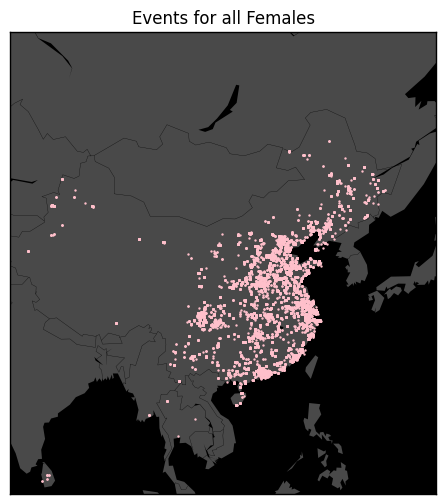

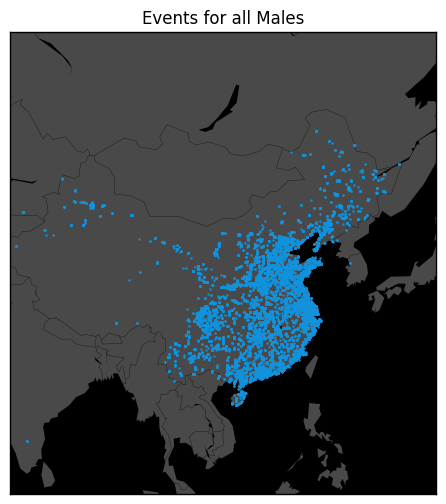

In [130]:
male_df_sample = train_events_with_location_sample[train_events_with_location_sample['gender'] == 'M']
female_df_sample = train_events_with_location_sample[train_events_with_location_sample['gender'] == 'F']

plot_geospatial_visualisation(female_df_sample, 'Events for all Females', color = 'pink')
plot_geospatial_visualisation(male_df_sample, 'Events for all Males')

From the above two graph we see that the **density** of events from male population is higher than females, but geospatial distribution looks similar.

In [131]:
male_df_sample.shape

(72896, 12)

In [132]:
female_df_sample.shape

(27104, 12)

This info mathces with the gender distribution count plot we have done above

**Plotting by age for these cateogries**

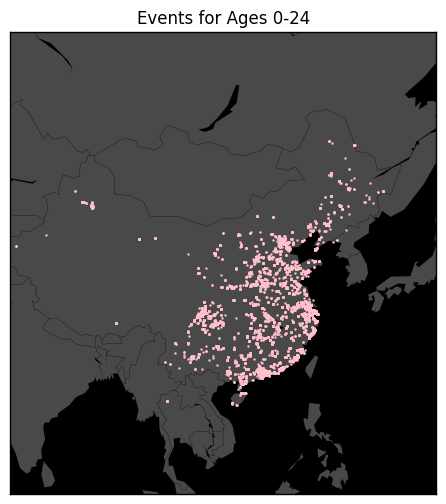

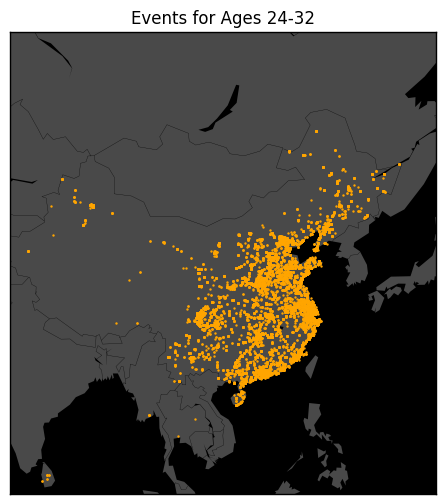

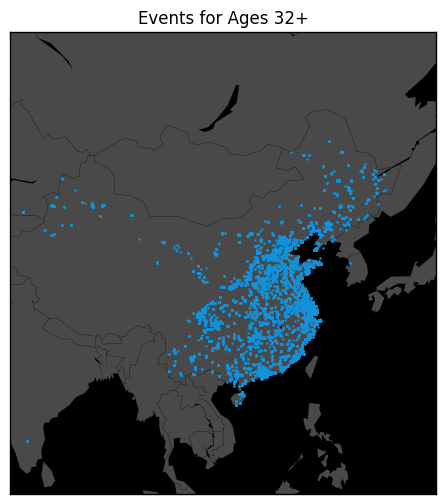

In [133]:
# Define the age bins
bins = [0, 24, 32, float('inf')]
labels = ['0-24', '25-32', '32+']

# Create age bins using cut
train_events_with_location_sample['age_group'] = pd.cut(train_events_with_location_sample['age'], bins=bins, labels=labels)

# Split DataFrame into three based on age groups
train_events_df_0_24 = train_events_with_location_sample[train_events_with_location_sample['age_group'] == '0-24']
train_events_df_25_32 = train_events_with_location_sample[train_events_with_location_sample['age_group'] == '25-32']
train_events_df_32_plus = train_events_with_location_sample[train_events_with_location_sample['age_group'] == '32+']

# Now you can use these three DataFrames to plot the world map
plot_geospatial_visualisation(train_events_df_0_24, 'Events for Ages 0-24', color = 'pink')
plot_geospatial_visualisation(train_events_df_25_32, 'Events for Ages 24-32', color = 'orange')
plot_geospatial_visualisation(train_events_df_32_plus, 'Events for Ages 32+')

#### DBSCAN Based Clustering

In [134]:
train_events_unique_location = train_events_with_location[~((train_events_with_location.latitude == 0) |  (train_events_with_location.longitude == 0))][["latitude", "longitude"]].drop_duplicates(subset=None, keep="first")

train_events_unique_location.shape

(32918, 2)

In [135]:
KMsPerRadian = 6371.0088

# epsilon = np.ones(coords.shape[0]) * 0.1 / kms_per_radian
eps_value = 100/ KMsPerRadian
coords = train_events_unique_location.loc[:, ["latitude", "longitude"]].values
dbscan = DBSCAN(eps= eps_value, algorithm = 'ball_tree', metric = 'haversine').fit(np.radians(coords))

cluster_labels = dbscan.labels_
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(num_clusters)

24


In [136]:
train_events_unique_location["cluster"] = cluster_labels

train_events_unique_location["coordinates"]=train_events_unique_location[["latitude", "longitude"]].apply(lambda x:(x["latitude"],x["longitude"]), axis = 1)

train_events_with_location = pd.merge(train_events_with_location, train_events_unique_location,how="inner",on="coordinates")
train_events_with_location.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude_x,longitude_x,day_of_week,hour,age_group,coordinates,latitude_y,longitude_y,cluster
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79,Tuesday,15.0,33-45,"(33.98, 116.79)",33.98,116.79,0
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79,Tuesday,6.0,33-45,"(33.98, 116.79)",33.98,116.79,0
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79,Wednesday,3.0,33-45,"(33.98, 116.79)",33.98,116.79,0
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79,Wednesday,2.0,33-45,"(33.98, 116.79)",33.98,116.79,0
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79,Tuesday,15.0,33-45,"(33.98, 116.79)",33.98,116.79,0


In [137]:
# We will now create a data frame from this clustering logic which will have a cluster for all the device id
device_cluster_df=train_events_with_location.groupby(['device_id'])[['cluster']].agg(lambda x:x.mode().iat[0])

device_cluster_df.head()

,cluster
device_id,
-9222956879900150000,0
-9221026417907250000,0
-9220061629197650000,0
-9218769147970100000,0
-9215352913819630000,0


We have done DBSCAN based clustering creating 24 clusters. Each location is now assigned a cluster ID from 0-23 which will be used in our model training as part of Data set preparation.


## 5. Feature Engineering - Scenario 1

##### 5.1 Event at different time of the day

First we will assign time of day for each of the device & event based on different times. The distribution are:
1. 20-05 : Night
2. 5-12: Morning
3. 12-16: Afternoon
4. 16-20: Evening

In [138]:
# Define the bins for timeframe
bins = [0, 5, 12, 16, 20, 24]

# Define the labels for timeframe
labels = ['Night', 'Morning', 'Afternoon', 'Evening', "Night"]

train_events_with_location["time_of_day"]=pd.cut(train_events_with_location.hour,bins=bins,labels=labels,ordered=False,include_lowest=True)
train_events_with_location.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude_x,longitude_x,day_of_week,hour,age_group,coordinates,latitude_y,longitude_y,cluster,time_of_day
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79,Tuesday,15.0,33-45,"(33.98, 116.79)",33.98,116.79,0,Afternoon
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79,Tuesday,6.0,33-45,"(33.98, 116.79)",33.98,116.79,0,Morning
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79,Wednesday,3.0,33-45,"(33.98, 116.79)",33.98,116.79,0,Night
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79,Wednesday,2.0,33-45,"(33.98, 116.79)",33.98,116.79,0,Night
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79,Tuesday,15.0,33-45,"(33.98, 116.79)",33.98,116.79,0,Afternoon


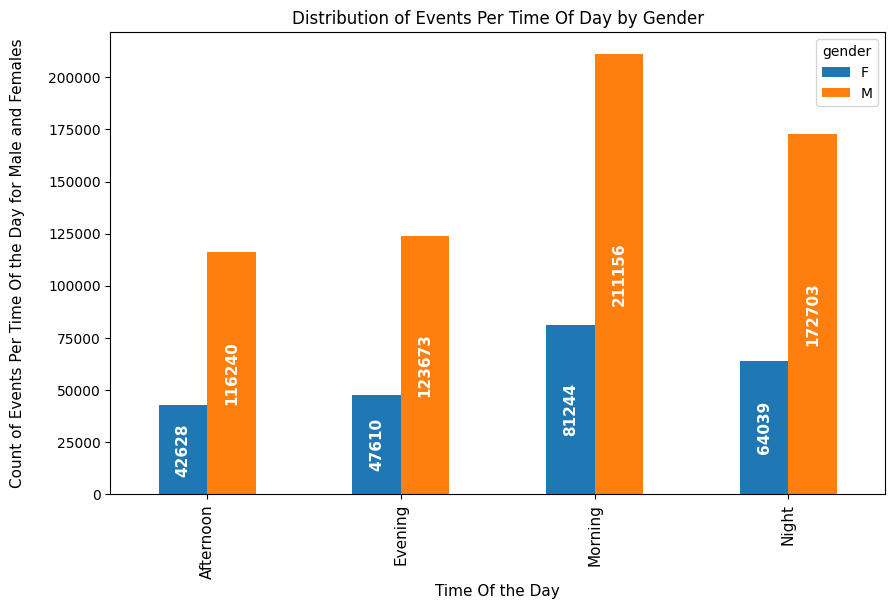

In [139]:
res = train_events_with_location.groupby(['time_of_day', 'gender']).size().unstack().plot(kind='bar', figsize=(10,6))

plt.title("Distribution of Events Per Time Of Day by Gender")

plt.setp( res.xaxis.get_majorticklabels(),fontsize=11)
res.set_xlabel(xlabel="Time Of the Day",fontsize=11)
res.set_ylabel(ylabel="Count of Events Per Time Of the Day for Male and Females\n",fontsize=11)

for x in res.containers:
    res.bar_label(x, label_type='center', fontweight="bold", color='white', fontsize=11, rotation = 90)

plt.grid(False)
plt.show()

Most events are generated during the morning hours, followed by the night hours.

Next we will try to determine if the traveller is frequent or infrequent along with their corresponding device location in the morning or evening

In [140]:
# Getting records with location
train_events_with_location=train_events_with_location[train_events_with_location["coordinates"]!=(0,0)]

# Merging Morning and Afternoon together, while Evening and Night Together for simplistic calculation
train_events_with_location["time_of_day"]=train_events_with_location["time_of_day"].apply(lambda x: "Evening" if x == "Night" else "Morning" if x == "Afternoon" else x)

# Getting Mode of "Coordinates" to get the maximum time a device was in at Morning or Evening
device_location_at_time_of_day = train_events_with_location.groupby(['device_id', 'time_of_day'])["coordinates"].agg(lambda x:x.mode().iat[0]).reset_index().pivot(index="device_id",columns="time_of_day", values = "coordinates").reset_index()

# Filling missing location as 0
device_location_at_time_of_day.fillna(0,inplace=True)

# Set if device user is frequent traveller throught a day
device_location_at_time_of_day["traveller_type"]=device_location_at_time_of_day.apply(lambda x: "Infrequent" if x["Evening"]==x["Morning"] else "Infrequent" if x["Evening"]==0 or x["Morning"]==0 else "Frequent",axis =1)

device_location_at_time_of_day

time_of_day,device_id,Evening,Morning,traveller_type
0,-9222956879900150000,"(23.19, 113.24)","(23.19, 113.24)",Infrequent
1,-9221026417907250000,"(30.87, 114.36)","(30.87, 114.36)",Infrequent
2,-9220061629197650000,"(46.6, 124.91)","(46.6, 124.91)",Infrequent
3,-9218769147970100000,"(28.6, 112.33)",0,Infrequent
4,-9215352913819630000,0,"(22.66, 114.02)",Infrequent
...,...,...,...,...
11975,9215085115859650000,"(41.81, 123.46)",0,Infrequent
11976,9216925254504440000,"(31.32, 120.56)","(31.32, 120.56)",Infrequent
11977,9219164468944550000,"(30.27, 120.17)","(30.24, 120.16)",Frequent
11978,9219842210460030000,"(26.52, 101.72)",0,Infrequent


In [141]:
device_location_at_time_of_day[device_location_at_time_of_day.traveller_type == "Frequent"]

time_of_day,device_id,Evening,Morning,traveller_type
18,-9177461074950570000,"(23.68, 113.03)","(23.67, 113.04)",Frequent
25,-9167960113940180000,"(34.91, 114.95)","(31.29, 120.57)",Frequent
33,-9155576106019230000,"(32.02, 118.83)","(32.03, 118.78)",Frequent
39,-9148504360104380000,"(39.76, 98.3)","(38.94, 100.46)",Frequent
45,-9139757358587510000,"(28.63, 115.85)","(28.68, 115.88)",Frequent
...,...,...,...,...
11961,9192128233312170000,"(31.14, 121.6)","(31.15, 121.36)",Frequent
11962,9194258367022970000,"(29.87, 115.18)","(29.85, 115.21)",Frequent
11966,9197208496589780000,"(35.52, 104.51)","(26.12, 99.96)",Frequent
11972,9205029352332710000,"(35.92, 114.68)","(35.94, 114.7)",Frequent


##### 5.2 Category mapping to higher level categories

In [142]:
app_event_meta_data_df.category.value_counts(dropna=False)

category
Custom label                                                                  53483
Industry tag                                                                  50271
Tencent                                                                       48945
game                                                                          48332
Property Industry 2.0                                                         45697
                                                                              ...  
online shopping by group\n-861266404539539653,129,online shopping by group        1
online shopping by group\n6041398007802129062,129,online shopping by group        1
online shopping by group\n3099701184811329097,129,online shopping by group        1
online shopping by group\n7290143846037231304,129,online shopping by group        1
File Editor                                                                       1
Name: count, Length: 492, dtype: int64

In [143]:
category_mapping={'DS_P2P net loan' : 'Finance', 'Securities' : 'Finance', 'Lottery ticket' : 'Game', 
'IMF' : 'Finance', 'Precious Metals' : 'Finance', 'pursue' : 'Education',
'Science and Technology' : 'Education', 'Customization' : 'Shopping', 'service' : 'Services', 
'Smart Shopping' : 'Shopping', 'Personal Effectiveness' : 'Education', 'vitality' : 'Shopping',
'Trendy / cool' : 'Shopping', 'Relatives' : 'Social', 'comfortable' : 'Shopping', 'Simple' : 'Shopping',
'Debit and credit' : 'Finance', 'Crowdfunding financing' : 'Finance', 'Custom label' : 'Shopping', 
'Ping' : 'Finance', 'safety Insurance' : 'Finance', 'Peace - Search' : 'General', 
'mobile bank' : 'Finance', 'Direct Bank' : 'Finance', 'futures' : 'Finance', 
'Property Industry 1.0' : 'Finance', 'Industry tag' : 'Business', 'Pay' : 'Finance',
'Wealth Management' : 'Finance', 'Customized 1' : 'NA', '1 free' : 'NA', 'Cozy 1' : 'Shopping',
'Services 1' : 'Shopping', 'Pursuit 1' : 'Shopping', 'Noble 1' : 'Shopping', 'Trendy / cool 1' : 'Shopping',
'Passion 1' : 'Shopping', 'Personal Effectiveness 1' : 'Shopping', 'Total Cost 1' : 'Shopping', 
'Smart Shopping 1' : 'Shopping', 'Science and Technology 1' : 'Education', 'Relatives 1' : 'Social',
'1 vitality' : 'Shopping', 'Irritation / Fun 1' : 'Entertainment', 'Quality 1' : 'Shopping', 
'1 reputation' : 'General', 'Nature 1' : 'Nature', 'Simple 1' : 'Others', 'Classical 1' : 'Entertainment',
'Property Industry 2.0' : 'Finance', 'Occupational identity' : 'Others', 'College Students' : 'Education',
'Condition of the vehicles' : 'Travel', 'Bank financing' : 'Finance', 'Internet banking' : 'Finance', 
'stock' : 'Finance', 'Insurance' : 'Finance', 'other' : 'Others', 'fund' : 'Finance', 
'Stock Futures' : 'Finance', 'Trust' : 'Finance', 'Consumer loans' : 'Finance',
'Financial Services' : 'Finance', 'fixed income' : 'Finance', 'P2P' : 'Finance', 'Direct Banking' : 'Finance',
'Crowdfunding' : 'Finance', 'A shares' : 'Finance', 'Life Insurance' : 'Finance', 
'Financial Supermarket' : 'Finance', 'exchange rate' : 'Finance', 'Financial Information' : 'Finance',
'Commodity Futures' : 'Finance', 'Monetary Fund' : 'Finance', 'Bond Fund' : 'Finance', 
'Real Estate Trust' : 'Finance', 'Third party payment' : 'Finance', 'Antique collection' : 'Shopping',
'Other shares' : 'Finance', 'H shares' : 'Finance', 'Financial Futures' : 'Finance', 
'Equity Fund' : 'Finance', 'Trust funds' : 'Finance', 'N shares' : 'Finance', 'Low risk' : 'Finance', 
'Low Risk' : 'Finance', 'Medium risk' : 'Finance', 'High risk' : 'Finance', 'Liquid medium' : 'Finance', 
'Lower liquidity' : 'Finance', 'Low liquidity' : 'Finance', 'High mobility' : 'Finance', 
'High Flow' : 'Finance', 'Low profitability' : 'Finance', 'Low income' : 'Finance', 
'Moderate profitability' : 'Finance', 'Higher income' : 'Finance', 'High profitability' : 'Finance',
'And the Church' : 'Religion', 'Direct Insurance' : 'Finance', 'Exchange' : 'Finance', 
'Casual puzzle categories' : 'Game', 'ARPG' : 'Game', 'MMO' : 'Game', 'Cards RPG' : 'Game', 
'The elimination of class' : 'Game', 'read' : 'Education', 'MOBA' : 'Game', 
'Pirated content' : 'Entertainment', 'SLG (strategy)' : 'Game', 'Chess categories' : 'Game', 
'Tower Defense' : 'Game', 'Flight Shooting' : 'Game', 'Online booking class' : 'Travel', 
'Other Read' : 'Entertainment', 'Racing (RAC)' : 'Game', 'Parkour avoid class' : 'Game', 'round' : 'General',
'Shootout Shooting (STG)' : 'Game', 'Business simulation' : 'Game', 'music' : 'Entertainment',
'Listening to books category' : 'Entertainment', '"Read the operators"' : 'Education', 'Buy class' : 'Travel',
'Sports' : 'Sports', 'User Community' : 'General', 'Vermicelli' : 'Grocery', 
'Animation aggregate class' : 'Art', 'Class animation community' : 'Art', 'Hardware Related' : 'Technology',
'game' : 'Game', 'literature' : 'Entertainment', 'the film' : 'Entertainment', 'Animation' : 'Game',
'Tencent' : 'Game', 'Comics Reading Tools' : 'Game', 'Doctors' : 'Health', 'Pregnant baby' : 'Heallth',
'Prepare baby' : 'Health', 'Maternal and child population' : 'Health', 'Parenting stage' : 'Education',
'Families with big baby' : 'Social', 'Families with small babies' : 'Social', 
'Families with babies' : 'Social', 'noble' : 'General', 'Total Cost' : 'Finance', 'natural' : 'Nature',
'quality' : 'Shopping', 'Cool trendy' : 'Fashion', 'Reputation' : 'Others', 'Enthusiasm' : 'Others',
'classical' : 'Others', 'Stimulate fun' : 'Entertainment', 'Property Industry new' : 'Finance',
'Low Cost Airlines' : 'Travel', 'High-end business aviation' : 'Business',
'Full Service Airlines' : 'Travel', 'General Aviation' : 'Travel', 'Regional Aviation' : 'Travel',
'Airline type' : 'Travel', 'aviation' : 'Travel', 'Air Travel' : 'Travel', 'Airline Alliances' : 'Travel',
'Aeronautical Information Service' : 'Travel', 'airport' : 'Travel',
'Aviation Integrated Services' : 'Travel', 'Southeast Asia (aviation)' : 'Travel', '"Hong Kong' : 'Travel',
'"Europe' : 'Travel', 'Japan and South Korea (Air)' : 'Travel', 'Chinese mainland (Airlines)' : 'Travel',
'Flight area' : 'Travel', 'Travel Travel' : 'Travel', 'Overseas travel' : 'Travel',
'Domestic travel' : 'Travel', 'Tour around' : 'Travel', 'Integrated tourism' : 'Travel',
'Purpose of travel' : 'Travel', 'travel' : 'Travel', 'Free exercise' : 'Travel',
'Travel Information' : 'Travel', 'Share Tour' : 'Travel', 'Travel preferences' : 'Travel',
'Southeast Asia (Travel)' : 'Travel', 'Japan and South Korea (Travel)' : 'Travel',
'Destination Region' : 'Travel', 'High-speed rail train reservation' : 'Travel',
'Integrated Air Travel Booking' : 'Travel', 'Integrated ticket reservation' : 'Travel',
'Book hotel complex' : 'Travel', 'Coach reservations' : 'Travel', 'Booking channels' : 'Travel',
'High-end hotel' : 'Travel', 'Hotel Chain' : 'Travel', 'Non-standard accommodation' : 'Travel',
'Hotel Type' : 'Travel', 'Hotels' : 'Travel', 'financial' : 'Finance', 'Xian Xia' : 'Others',
'effort' : 'Others', 'navigation' : 'Travel', 'Tomb' : 'Others', 'reality show' : 'Entertainment',
'Jin Yong' : 'Others', 'Senki' : 'Others', 'Journey' : 'Travel', 'tribe' : 'Others', 'Ninja' : 'Game',
'Romance' : 'Entertainment', 'Shushan' : 'Entertainment', 'Martial arts' : 'Art',
'Domestic animation' : 'Art', 'Europe and Fantasy' : 'Travel', 'Harem' : 'Game', 'trickery' : 'Game',
'fashion' : 'Fashion', 'game-Cutting things' : 'Game', 'game-Finding fault' : 'Game',
'game-stress reliever' : 'Game', 'game-pet' : 'Game', 'game-Answer' : 'Game', 'game-Fishing' : 'Game',
'game-Music and Dance' : 'Game', 'game-Puzzle' : 'Game', 'game-Adventure puzzle' : 'Game',
'game-Parkour' : 'Game', 'game-Racing' : 'Game', 'game-Motorcycle' : 'Game', 'game-Rowing' : 'Game',
'game-aircraft' : 'Game', 'game-Box' : 'Game', 'game-gem' : 'Game', 'game-Lianliankan' : 'Game',
'game-Zuma' : 'Game', 'game-Bobble' : 'Game', 'game-Cartoon' : 'Game', 'game-Role -playing games' : 'Game',
'game-Competitive action' : 'Game', 'game-Tactics' : 'Game', 'game-card' : 'Game',
'game-Business simulation' : 'Game', 'game-Horizontal version' : 'Game', 'game-shooting' : 'Game',
'game-3D' : 'Game', 'game-flight' : 'Game', 'game-tank' : 'Game', 'game-Snipe' : 'Game',
'poker game_doudizhu' : 'Game', 'chess' : 'Game', 'majiang' : 'Game', 'table game' : 'Game',
'Texas Poker' : 'Game', 'poker' : 'Game', 'Puzzle' : 'Game', 'Literacy Games' : 'Game',
'Intellectual development game' : 'Game', 'math' : 'Education', 'checkpoints game' : 'Game',
'Beach landing game' : 'Game', 'old style game' : 'Game', 'basketball' : 'Game', 'football' : 'Game',
'tennis' : 'Game', 'billards' : 'Game', 'other ball game' : 'Game', 'Turn based RPG game' : 'Game',
'realtime fighting' : 'Game', 'war chess' : 'Game', 'business' : 'Game', 'farm' : 'Game',
'pet raising up' : 'Game', 'love raising up' : 'Game', 'puzzel' : 'Game', 'gambling' : 'Game',
'3 kindom game' : 'Game', 'knight game' : 'Game', 'Cultivation fantasy game' : 'Game',
'Journey to the West game' : 'Game', 'Outlaws of the Marsh game' : 'Game',
'Chinese Classical Mythology' : 'Game', 'Western Mythology' : 'Game',
'80s Japanese comic' : 'Entertainment', '90s Japanese comic' : 'Game', 'movie' : 'Entertainment',
'shows' : 'Entertainment', 'millitary and wars' : 'Entertainment', 'science fiction' : 'Entertainment',
'zombies game' : 'Entertainment', 'World of Warcraft' : 'Entertainment', 'magic' : 'Entertainment',
'dotal-lol' : 'Others', 'sailing game' : 'Game', 'sports' : 'Sports', 'Chinese painting' : 'Art',
'japanese and korean style' : 'Art', 'japanese comic and animation' : 'Entertainment',
'US and Europe animation' : 'Entertainment', 'Cute style comic' : 'Entertainment',
'pixel style comic' : 'Entertainment', 'violence comic' : 'Entertainment',
'US and Europe magic comic' : 'Entertainment', 'realistic style comic' : 'Entertainment',
'chinese comic' : 'Entertainment', 'online malls' : 'Shopping', '"online shopping by group' : 'Shopping',
'online shopping navigation' : 'Shopping', '"online shopping' : 'Shopping',
'Sea Amoy' : 'Others', 'education for babies' : 'Education', 'education outside class' : 'Education',
'foreign language' : 'Education', 'professional skills' : 'Education',
'art and culture' : 'Art', 'exams' : 'Education', 'class managemetn' : 'Education',
'children books' : 'Education', 'novels' : 'Education', 'magazine and journal' : 'Education',
'comics' : 'Education', 'dictionary' : 'Education', 'reading platform' : 'Education',
'poetry' : 'Art', 'joke' : 'Education', 'Audiobooks' : 'Education', 'science' : 'Education',
'news' : 'Education', 'Entertainment News' : 'Education', 'Sports News' : 'Education',
'Technology Information' : 'Education', 'gaming strategy' : 'Game', 'weibo' : 'Others', 
'love and marriage' : 'Social', 'community' : 'Social', 'picture sharing' : 'Social',
'radio' : 'Social', 'video' : 'Entertainment', 'show' : 'Entertainment',
'map' : 'Travel', 'Behalf of the drive' : 'Others', 'Taxi' : 'Travel', 'Car' : 'Travel',
'flight' : 'Travel', 'Bus' : 'Travel', 'train' : 'Travel', 'Hotel application' : 'Travel',
'tourism product' : 'Travel', 'coach transport' : 'Travel', 'Decoration' : 'Shopping',
'Appliances' : 'Shopping', 'Furniture' : 'Shopping', 'household products' : 'Shopping',
'Smart Home' : 'Shopping', 'Smart Appliances' : 'Shopping', 'lose weight' : 'Health',
'sports and gym' : 'Health', 'health' : 'Health', 'Medical' : 'Health',
'Health Management' : 'Health', 'Wearable Health' : 'Health', 'IM' : 'Game',
'pictures photography' : 'Photography', 'Man playing favorites' : 'Game', 'takeaway ordering' : 'Shopping',
'Astrology Horoscope' : 'Astrology', 'Reviews' : 'Entertainment', 'Recipes' : 'Education',
'Express' : 'Social', 'Accounting' : 'Education', 'Car Owners' : 'Social', 'fashion outfit' : 'Fashion',
'Integrated Living' : 'Social', 'Jobs' : 'Business', 'Scheduling' : 'Business', 'notes' : 'Business',
'File Editor' : 'Business', 'business cards' : 'Business', 'Contacts' : 'Business',
'network disk' : 'Business', 'store management' : 'Business', 'Engineering Drawing' : 'Education',
'Housing Advice' : 'Business', 'KTV' : 'Entertainment', 'Automotive News' : 'Education',
'Sale of cars' : 'Business', 'A beauty care' : 'Fashion', 'Intelligent hardware' : 'Technology',
'study abroad' : 'Education', 'RPG game' : 'Game', 'poker and chess' : 'Game',
'business strategy game' : 'Game', 'game-game type' : 'Game', 'game-Art Style' : 'Game',
'game-Gem Elimination' : 'Game', 'fighting game' : 'Game', 'raising up game' : 'Game',
'Guard tower defense game' : 'Game', 'game-Leisure time' : 'Game', 'Children puzzle game' : 'Game',
'convenience services' : 'Services', 'Beauty Nail' : 'Fashion', 'blogs' : 'Social',
'Housekeeping' : 'Services', 'System Tools' : 'Technology', 'Utilities' : 'General',
'Prepare pregnant pregnancy' : 'Health', 'Maternal and child supplies' : 'Health',
'Points Activities' : 'Others', 'management' : 'Business', 'Browser' : 'Technology',
'Desktop Enhancements' : 'Technology', 'Parenting' : 'Education', 'Buy' : 'Shopping',
'Rentals' : 'Travel', 'Weather' : 'Travel', 'coupon' : 'Shopping', 'Travel advisory' : 'Travel',
'Calendar' : 'General', 'shopping sharing' : 'Shopping', 'Clock' : 'General', 'WIFI' : 'Technology',
'Information' : 'Education', 'Share Travels' : 'Travel', 'App Store' : 'Shopping', 'Sellers' : 'Shopping',
'entertainment' : 'Entertainment', 'Academic Information' : 'Education', 'email' : 'General',
'Mother' : 'Social', 'phone' : 'General', 'psychology' : 'Education', 'Business Office' : 'Business',
'Estate' : 'Finance', 'search' : 'General', 'Make-up application' : 'Fashion',
'Skin care applications' : 'Health', 'Traditional securities brokerage' : 'Finance', 
'P2P net loan' : 'Finance', 'Third-party card management' : 'Finance',
'Internet Banking' : 'Finance', 'Consumer Finance' : 'Finance', 'Traditional Insurance' : 'Finance',
'Heritage Foundation' : 'Finance', 'Internet Securities' : 'Finance', 'Bank Credit Card' : 'Finance',
'Internet Insurance' : 'Finance', 'library' : 'Education', 'readers' : 'Education',
'Editor' : 'General', 'reading for fetus' : 'Health', 'mesasge' : 'General',
'Card Game' : 'Game', 'strategy game' : 'Game', 'cosplay' : 'Game', 'casual games' : 'Game',
'Games' : 'Game', 'Puzzles' : 'Game', 'Sports Games' : 'Game', 'action games' : 'Game',
'Educational games' : 'Game', 'Chess game' : 'Game', 'Music Games' : 'Game', 'Adventure Game' : 'Game',
'Simulators' : 'Game', 'Racing games' : 'Game', 'Table Games' : 'Game', 'Family Games' : 'Game',
'Dice Game' : 'Game', 'Word games+' : 'Game', 'Finance':'Finance', 'Word games' : 'Game',
"Read the operator's":"Education"                  
}

In [144]:
category_mapping = {k.upper():v.upper() for k,v in category_mapping.items()}

In [145]:
app_event_meta_data_grouped_df=app_event_meta_data_df.copy()
app_event_meta_data_grouped_df['category'] = app_event_meta_data_grouped_df['category'].str.upper()
app_event_meta_data_grouped_df=app_event_meta_data_grouped_df[(app_event_meta_data_grouped_df["category"] != "FREE") & (app_event_meta_data_grouped_df["category"] != "UNKNOWN")]
app_event_meta_data_grouped_df["highlevelcategory"]=app_event_meta_data_grouped_df["category"].map(category_mapping)
app_event_meta_data_grouped_df=app_event_meta_data_grouped_df[["app_id","highlevelcategory"]]
app_event_meta_data_grouped_df=app_event_meta_data_grouped_df.drop_duplicates()

app_event_meta_data_grouped_df=app_event_meta_data_grouped_df.groupby("app_id").aggregate({"highlevelcategory":list}).reset_index()
app_event_meta_data_grouped_df["highlevelcategory"]=app_event_meta_data_grouped_df["highlevelcategory"].apply(lambda x: x[0])
app_event_meta_data_grouped_df

,app_id,highlevelcategory
0,-9223281467940916832,GAME
1,-9222877069545393219,EDUCATION
2,-9222785464897897681,GAME
3,-9222198347540756780,GAME
4,-9221970424041518544,NA
...,...,...
103081,9222307926049432405,GAME
103082,9222488106573038706,ENTERTAINMENT
103083,9222542043353102991,NA
103084,9222821882765325814,GAME


In [146]:
device_event_with_app_and_category_df=pd.merge(merged_df_for_apps,app_event_meta_data_grouped_df,how="left",on="app_id")

In [147]:
device_event_with_app_and_category_df["highlevelcategory"].fillna("UNKNOWN",inplace=True)
device_event_with_app_and_category_df.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude,day_of_week,hour,age_group,coordinates,app_id,is_installed,is_active,highlevelcategory
0,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",3433289601737013244,1,1,BUSINESS
1,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",-5472633337921616096,1,1,NATURE
2,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",9112463114311278255,1,0,NA
3,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",8693964245073640147,1,1,FINANCE
4,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",5099453940784075687,1,1,EDUCATION


In [148]:
device_event_with_app_and_category_df.highlevelcategory.value_counts(dropna=False)

highlevelcategory
FINANCE          3910238
SHOPPING         2219132
UNKNOWN          2173833
BUSINESS         1925730
NA                810573
EDUCATION         555972
SOCIAL            272143
GAME               87265
ENTERTAINMENT      85114
NATURE             69916
OTHERS             41489
RELIGION           31134
TRAVEL             16104
HEALTH              8347
GENERAL             7057
FASHION             6620
PHOTOGRAPHY         5859
SERVICES            4253
TECHNOLOGY          4003
HEALLTH             2052
ART                  225
ASTROLOGY            161
SPORTS                34
Name: count, dtype: int64

In [149]:
# We have multiple categories which are NA, we will change them to UNKNOWN
device_event_with_app_and_category_df.highlevelcategory = device_event_with_app_and_category_df.highlevelcategory.map(lambda x: "UNKNOWN" if x == "NA" else x)

# Validate that there are no more NA categories
device_event_with_app_and_category_df.highlevelcategory[device_event_with_app_and_category_df.highlevelcategory == "NA"].value_counts()

Series([], Name: count, dtype: int64)

In [150]:
device_event_with_app_and_category_df.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude,day_of_week,hour,age_group,coordinates,app_id,is_installed,is_active,highlevelcategory
0,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",3433289601737013244,1,1,BUSINESS
1,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",-5472633337921616096,1,1,NATURE
2,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",9112463114311278255,1,0,UNKNOWN
3,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",8693964245073640147,1,1,FINANCE
4,-7548291590301750000,M,33,M32+,1141870.0,2016-05-01 10:08:16,33.98,116.79,Sunday,10.0,33-45,"(33.98, 116.79)",5099453940784075687,1,1,EDUCATION


Now from this dataframe, we will get a new feature named top high level category for every device id

In [151]:
top_category_for_device_df = device_event_with_app_and_category_df[device_event_with_app_and_category_df["highlevelcategory"]!="UNKNOWN"].groupby("device_id")["highlevelcategory"].agg(lambda x: x.mode().iat[0]).reset_index()

top_category_for_device_df.head()

,device_id,highlevelcategory
0,-9222956879900150000,FINANCE
1,-9221026417907250000,FINANCE
2,-9220830859283100000,BUSINESS
3,-9220061629197650000,FINANCE
4,-9218960997324660000,BUSINESS


##### 5.3 Event count per device

In [152]:
device_event_count_df=train_events_with_location.groupby("device_id").count()["event_id"].reset_index()
device_event_count_df=device_event_count_df.rename(columns={"event_id":"event_count"})
device_event_count_df.head()

,device_id,event_count
0,-9222956879900150000,52
1,-9221026417907250000,132
2,-9220061629197650000,39
3,-9218769147970100000,17
4,-9215352913819630000,18


##### 5.4 Phone Brand & Device Model for every Device ID

In [153]:
mobile_brand_df = train_mobile_brand_df.groupby("device_id").aggregate({"phone_brand": list, "device_model": list}).reset_index()
mobile_brand_df["phone_brand"] = mobile_brand_df["phone_brand"].apply(lambda x: x[0])
mobile_brand_df["device_model"] = mobile_brand_df["device_model"].apply(lambda x: x[0])
mobile_brand_df.head()

,device_id,phone_brand,device_model
0,-9223067244542180000,VIVO,Y19T
1,-9222956879900150000,SAMSUNG,GALAXY NOTE 2
2,-9222754701995930000,COOLPAD,8730L
3,-9222352239947200000,XIAOMI,XNOTE11
4,-9222173362545970000,SAMSUNG,GALAXY NOTE 2


### Data Preparation

#### Merge all necessary Data Frames

In [154]:
device_data_df = train_events_with_location[["device_id", "gender", "age_group"]].drop_duplicates()
device_events_merged_df = pd.merge(device_data_df, device_location_at_time_of_day, how="left", on="device_id")
device_events_merged_df = pd.merge(device_events_merged_df, top_category_for_device_df, how="left", on="device_id")
device_events_merged_df = pd.merge(device_events_merged_df, device_cluster_df, how="left", on="device_id")
device_events_merged_df = pd.merge(device_events_merged_df, device_event_count_df, how="left", on="device_id")
device_events_merged_df = pd.merge(device_events_merged_df, mobile_brand_df, how="left", on="device_id")
print("Shape of merged df = ", device_events_merged_df.shape)
device_events_merged_df.head()

Shape of merged df =  (11980, 11)


,device_id,gender,age_group,Evening,Morning,traveller_type,highlevelcategory,cluster,event_count,phone_brand,device_model
0,-7548291590301750000,M,33-45,"(33.98, 116.79)","(33.98, 116.79)",Infrequent,BUSINESS,0,292,HUAWEI,3C
1,4543988487649880000,M,46+,"(30.88, 104.26)","(30.92, 104.25)",Frequent,FINANCE,0,39,SAMSUNG,GALAXY S4
2,-1819925713085810000,F,0-24,"(36.32, 114.59)","(36.33, 114.59)",Frequent,BUSINESS,0,38,OPPO,N1 MINI
3,3585775875204580000,F,46+,0,"(35.3, 111.66)",Infrequent,FINANCE,0,14,XIAOMI,MI 4
4,7442042493953950000,M,25-32,"(39.43, 116.98)",0,Infrequent,FINANCE,0,2,HUAWEI,HU1 PLUS


In [155]:
device_events_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11980 entries, 0 to 11979
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   device_id          11980 non-null  int64   
 1   gender             11980 non-null  object  
 2   age_group          11980 non-null  category
 3   Evening            11980 non-null  object  
 4   Morning            11980 non-null  object  
 5   traveller_type     11980 non-null  object  
 6   highlevelcategory  11960 non-null  object  
 7   cluster            11980 non-null  int64   
 8   event_count        11980 non-null  int64   
 9   phone_brand        11980 non-null  object  
 10  device_model       11980 non-null  object  
dtypes: category(1), int64(3), object(7)
memory usage: 948.0+ KB


We will do some further cleanup of this merged data frame

In [156]:
# we have gathered the traveller type from cordinate data, we will drop morning and evening columns
device_events_merged_df.drop(["Morning", "Evening"], axis=1, inplace=True)

device_events_merged_df["traveller_type"].fillna("Unknown", inplace=True)

device_events_merged_df["cluster"].fillna(-99,inplace=True)

device_events_merged_df["cluster"] = device_events_merged_df["cluster"].astype("category")

device_events_merged_df.head()

,device_id,gender,age_group,traveller_type,highlevelcategory,cluster,event_count,phone_brand,device_model
0,-7548291590301750000,M,33-45,Infrequent,BUSINESS,0,292,HUAWEI,3C
1,4543988487649880000,M,46+,Frequent,FINANCE,0,39,SAMSUNG,GALAXY S4
2,-1819925713085810000,F,0-24,Frequent,BUSINESS,0,38,OPPO,N1 MINI
3,3585775875204580000,F,46+,Infrequent,FINANCE,0,14,XIAOMI,MI 4
4,7442042493953950000,M,25-32,Infrequent,FINANCE,0,2,HUAWEI,HU1 PLUS


In [157]:
device_events_merged_df.columns

Index(['device_id', 'gender', 'age_group', 'traveller_type',
       'highlevelcategory', 'cluster', 'event_count', 'phone_brand',
       'device_model'],
      dtype='object')

#### Encoding

We will now convert the string values to numeric values by doing various encoding

##### LabelEncoder

In [158]:
#Defining Target Columns
target_columns = ['gender', 'age_group']

# Create an instance of the LabelEncoder
encoder = LabelEncoder()

# Apply label encoding on the selected columns
device_events_merged_encoded_df = device_events_merged_df.copy()
label_mappings = {}

for column in target_columns:
    encoded_labels = encoder.fit_transform(device_events_merged_df[column])
    device_events_merged_encoded_df[column] = encoded_labels
    label_mappings[column] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# Print the mappings for each column
for column, mappings in label_mappings.items():
    print(f"Label Mappings for column '{column}':")
    for label, encoded_label in mappings.items():
        print(f"{label} : {encoded_label}")
    print()

Label Mappings for column 'gender':
F : 0
M : 1

Label Mappings for column 'age_group':
0-24 : 0
25-32 : 1
33-45 : 2
46+ : 3



In [159]:
device_events_merged_encoded_df.head()

,device_id,gender,age_group,traveller_type,highlevelcategory,cluster,event_count,phone_brand,device_model
0,-7548291590301750000,1,2,Infrequent,BUSINESS,0,292,HUAWEI,3C
1,4543988487649880000,1,3,Frequent,FINANCE,0,39,SAMSUNG,GALAXY S4
2,-1819925713085810000,0,0,Frequent,BUSINESS,0,38,OPPO,N1 MINI
3,3585775875204580000,0,3,Infrequent,FINANCE,0,14,XIAOMI,MI 4
4,7442042493953950000,1,1,Infrequent,FINANCE,0,2,HUAWEI,HU1 PLUS


##### Standard Scaler

In [160]:
num_columns=["event_count"]

# Apply StandardScaler
scaler = StandardScaler()
device_events_merged_encoded_df[num_columns] = scaler.fit_transform(device_events_merged_encoded_df[num_columns].values)

In [161]:
device_events_merged_encoded_df.head()

,device_id,gender,age_group,traveller_type,highlevelcategory,cluster,event_count,phone_brand,device_model
0,-7548291590301750000,1,2,Infrequent,BUSINESS,0,1.398279,HUAWEI,3C
1,4543988487649880000,1,3,Frequent,FINANCE,0,-0.207751,SAMSUNG,GALAXY S4
2,-1819925713085810000,0,0,Frequent,BUSINESS,0,-0.214099,OPPO,N1 MINI
3,3585775875204580000,0,3,Infrequent,FINANCE,0,-0.366450,XIAOMI,MI 4
4,7442042493953950000,1,1,Infrequent,FINANCE,0,-0.442625,HUAWEI,HU1 PLUS


##### TargetEncoder

For converting other values such as traveller_type, highlevelcateogry, cluster etc, we will use TargetEncoder

In [162]:
target_columns = ['gender']

cat_columns = ["traveller_type", "highlevelcategory", "cluster", "phone_brand", "device_model"]
encoder = category_encoders.TargetEncoder(cols=cat_columns)

encoder.fit(device_events_merged_encoded_df, device_events_merged_encoded_df["gender"])

device_events_merged_encoded_df = encoder.transform(device_events_merged_encoded_df)

In [163]:
device_events_merged_encoded_df.head()

,device_id,gender,age_group,traveller_type,highlevelcategory,cluster,event_count,phone_brand,device_model
0,-7548291590301750000,1,2,0.696701,0.589212,0.707334,1.398279,0.734277,0.713415
1,4543988487649880000,1,3,0.743972,0.719878,0.707334,-0.207751,0.693680,0.663796
2,-1819925713085810000,0,0,0.743972,0.589212,0.707334,-0.214099,0.597403,0.479366
3,3585775875204580000,0,3,0.696701,0.719878,0.707334,-0.366450,0.712083,0.714556
4,7442042493953950000,1,1,0.696701,0.719878,0.707334,-0.442625,0.734277,0.745318


### Train Test Split of Data

In [164]:
train_test_df = pd.read_csv("data/train_test_split.csv")

train_test_df.columns = ["device_id", "gender", "age", "group", "train_test_flag"]
train_test_df.head()

,device_id,gender,age,group,train_test_flag
0,-7548291590301750000,M,33,M32+,train
1,6943568600617760000,M,37,M32+,train
2,5441349705980020000,M,40,M32+,train
3,-5393876656119450000,M,33,M32+,train
4,4543988487649880000,M,53,M32+,train


In [165]:
device_events_train_test_merged_df=pd.merge(device_events_merged_encoded_df,train_test_df[["device_id","train_test_flag"]],how="inner",on="device_id")
device_events_train_test_merged_df.head()

,device_id,gender,age_group,traveller_type,highlevelcategory,cluster,event_count,phone_brand,device_model,train_test_flag
0,-7548291590301750000,1,2,0.696701,0.589212,0.707334,1.398279,0.734277,0.713415,train
1,4543988487649880000,1,3,0.743972,0.719878,0.707334,-0.207751,0.693680,0.663796,train
2,-1819925713085810000,0,0,0.743972,0.589212,0.707334,-0.214099,0.597403,0.479366,train
3,3585775875204580000,0,3,0.696701,0.719878,0.707334,-0.366450,0.712083,0.714556,train
4,7442042493953950000,1,1,0.696701,0.719878,0.707334,-0.442625,0.734277,0.745318,train


In [166]:
# Define the directory path
directory = 'model_input'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, 'device_events_train_test_merged.csv')

# Write the prepared database to a csv file which will be used in next notebook
device_events_train_test_merged_df.to_csv(file_path, index=False)

## 6. Feature Engineering & Data Preparation - Scenario 2

In [167]:
train_events_without_location.head()

,device_id,gender,age,group_train,age_group
1215595,398514470209561000,M,68,M32+,46+
1215596,-3073918292047050000,M,27,M25-32,25-32
1215597,5805880616488060000,M,39,M32+,33-45
1215598,-2403560729305410000,M,25,M25-32,25-32
1215599,-1889893391998300000,M,22,M0-24,0-24


In [168]:
device_without_location_merged = pd.merge(train_events_without_location, mobile_brand_df, how="left", on="device_id")

In [169]:
device_without_location_merged.shape

(51335, 7)

In [170]:
# Drop `group_train` as we don't need this for training
device_without_location_merged.drop(columns=['group_train'], inplace=True) 

In [171]:
device_without_location_merged.head()

,device_id,gender,age,age_group,phone_brand,device_model
0,398514470209561000,M,68,46+,HUAWEI,4X
1,-3073918292047050000,M,27,25-32,HUAWEI,4C
2,5805880616488060000,M,39,33-45,LSHI,1
3,-2403560729305410000,M,25,25-32,NIBILU,
4,-1889893391998300000,M,22,0-24,HUAWEI,3X


#### Label Encoding

In [172]:
#Defining Target Columns
target_columns = ['gender', 'age_group']

# Create an instance of the LabelEncoder
encoder = LabelEncoder()

# Apply label encoding on the selected columns
device_without_location_encoded_merged_df = device_without_location_merged.copy()
label_mappings = {}

for column in target_columns:
    encoded_labels = encoder.fit_transform(device_without_location_merged[column])
    device_without_location_encoded_merged_df[column] = encoded_labels
    label_mappings[column] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# Print the mappings for each column
for column, mappings in label_mappings.items():
    print(f"Label Mappings for column '{column}':")
    for label, encoded_label in mappings.items():
        print(f"{label} : {encoded_label}")
    print()

Label Mappings for column 'gender':
F : 0
M : 1

Label Mappings for column 'age_group':
0-24 : 0
25-32 : 1
33-45 : 2
46+ : 3



#### Target Encoding

In [173]:
target_columns = ['gender']

cat_columns = ["phone_brand", "device_model"]
encoder = category_encoders.TargetEncoder(cols=cat_columns)

encoder.fit(device_without_location_encoded_merged_df, device_without_location_encoded_merged_df["gender"])
device_without_location_encoded_merged_df=encoder.transform(device_without_location_encoded_merged_df)

device_without_location_encoded_merged_df.head()

,device_id,gender,age,age_group,phone_brand,device_model
0,398514470209561000,1,68,3,0.664493,0.664430
1,-3073918292047050000,1,27,1,0.664493,0.706468
2,5805880616488060000,1,39,2,0.689542,0.692912
3,-2403560729305410000,1,25,1,0.681667,0.720682
4,-1889893391998300000,1,22,0,0.664493,0.673285


In [174]:
device_without_location_train_test_merged_df=pd.merge(device_without_location_encoded_merged_df,train_test_df[["device_id","train_test_flag"]],how="inner",on="device_id")
device_without_location_train_test_merged_df.head()

,device_id,gender,age,age_group,phone_brand,device_model,train_test_flag
0,398514470209561000,1,68,3,0.664493,0.664430,train
1,-3073918292047050000,1,27,1,0.664493,0.706468,train
2,5805880616488060000,1,39,2,0.689542,0.692912,train
3,-2403560729305410000,1,25,1,0.681667,0.720682,train
4,-1889893391998300000,1,22,0,0.664493,0.673285,train


In [175]:
# Write the prepared database to a csv file which will be used in next notebook
device_without_location_train_test_merged_df.to_csv("model_input/device_without_location_train_test_merged.csv", index=False)

### END OF PART 1 - EDA, VISUALISATION & DATA PREPARATION

#### SURBHI SINHA